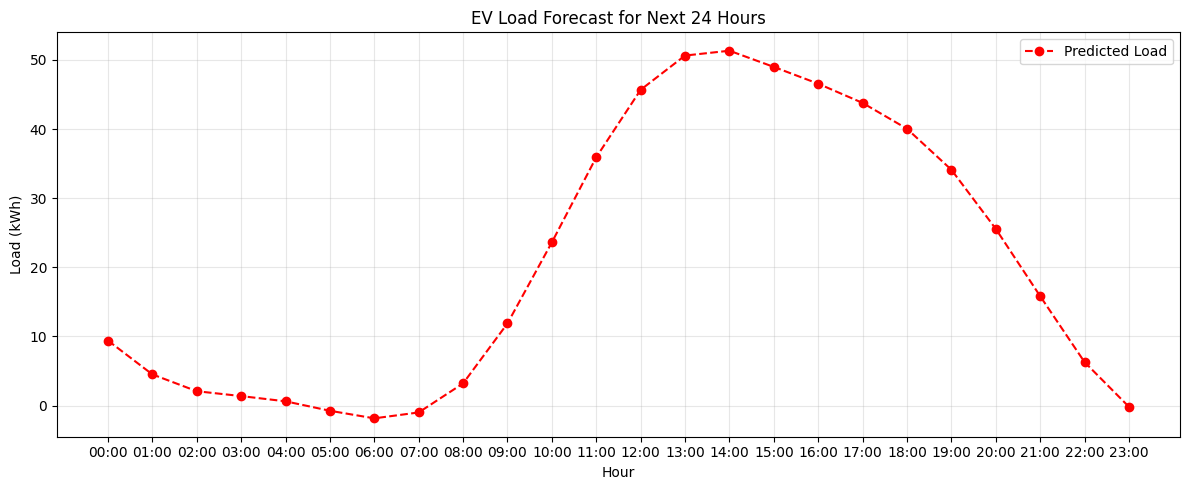

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import joblib
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# --- Load preprocessed data ---
data = pd.read_csv("F:\VidyutAI\data\hourlyEVusage_cleaned.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values('Datetime').reset_index(drop=True)
data.set_index('Datetime', inplace=True)

# --- Fill missing hours ---
complete_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
data = data.reindex(complete_range, fill_value=0)
data['Energy_kWh'] = data['Energy_kWh'].fillna(0)
data['Load'] = data['Energy_kWh'].rolling(window=3, center=True).mean().fillna(data['Energy_kWh'])

# --- Feature engineering ---
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Day'] = data.index.day
data['IsWeekend'] = data['DayOfWeek'].isin([5,6]).astype(int)
data['IsBusinessHour'] = ((data['Hour'] >= 8) & (data['Hour'] <= 18)).astype(int)
data['IsEvening'] = ((data['Hour'] >= 18) & (data['Hour'] <= 22)).astype(int)
data['Hour_sin'] = np.sin(2*np.pi*data['Hour']/24)
data['Hour_cos'] = np.cos(2*np.pi*data['Hour']/24)
data['DayOfWeek_sin'] = np.sin(2*np.pi*data['DayOfWeek']/7)
data['DayOfWeek_cos'] = np.cos(2*np.pi*data['DayOfWeek']/7)
data['Month_sin'] = np.sin(2*np.pi*data['Month']/12)
data['Month_cos'] = np.cos(2*np.pi*data['Month']/12)
data['Lag_1h'] = data['Load'].shift(1)
data['Lag_24h'] = data['Load'].shift(24)
data['Lag_48h'] = data['Load'].shift(48)
data['Lag_168h'] = data['Load'].shift(168)
data['Rolling_mean_6h'] = data['Load'].rolling(6).mean()
data['Rolling_mean_24h'] = data['Load'].rolling(24).mean()
data['Rolling_std_24h'] = data['Load'].rolling(24).std()
data['Rolling_max_24h'] = data['Load'].rolling(24).max()
data = data.dropna().reset_index()

# --- Sequence and static feature preparation ---
history_len = 48
forecast_len = 24

feature_cols = [
    'Hour','DayOfWeek','Month','Day','IsWeekend','IsBusinessHour','IsEvening',
    'Hour_sin','Hour_cos','DayOfWeek_sin','DayOfWeek_cos','Month_sin','Month_cos',
    'Lag_1h','Lag_24h','Lag_48h','Lag_168h','Rolling_mean_6h','Rolling_mean_24h',
    'Rolling_std_24h','Rolling_max_24h'
]

# --- Take the last sequence from data as input for prediction ---
X_seq_input = data['Load'].values[-history_len:]
X_static_input = data[feature_cols].iloc[-1].values.reshape(1, -1)

# --- Load CatBoost model and scalers ---
model_file = "catboost_ev_forecast.cbm"
package_file = "catboost_package.pkl"

cb_model = CatBoostRegressor()
cb_model.load_model(model_file)

package = joblib.load(package_file)
scaler_seq = package['scaler_seq']
scaler_static = package['scaler_static']
scaler_y = package['scaler_y']
feature_names = package['feature_names']

# --- Scale inputs ---
X_seq_scaled = scaler_seq.transform(X_seq_input.reshape(-1,1)).reshape(1, -1)
X_static_scaled = scaler_static.transform(X_static_input)

X_combined_input = np.concatenate([X_seq_scaled, X_static_scaled], axis=1)

# --- Predict next 24 hours ---
y_pred_scaled = cb_model.predict(X_combined_input)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# --- Plot predictions ---
plt.figure(figsize=(12,5))
plt.plot(range(24), y_pred, 'ro--', label='Predicted Load')
plt.xticks(range(0,24,1), [f"{h:02d}:00" for h in range(24)])
plt.xlabel("Hour")
plt.ylabel("Load (kWh)")
plt.title("EV Load Forecast for Next 24 Hours")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
